# Parameter Recovery in Log-Space Demo

In this demo, we show a parameter recovery using `psignifit`, in the case where we want to fit a sigmoid in log space. 

This demo is very similar to the "Parameter Recovery Demo", and you should have a look at that one first, but it also shows how to fit the sigmoid in log-space, and how to recover width, threshold, and confidence intercals in the original simulus space.

We will cover the following steps:

  1. Simulating data with known parameters.
  
  2. Fitting the model to the simulated data in logspace.

  3. Converting the fitted parameters back to stimulus space.
  
  4. Comparing the recovered parameters to the original parameters.


In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

import psignifit
from psignifit import psigniplot

First, we set parameters using which the data will be simulated

In [2]:
stim_range = [1.0, 1000.0]
threshold = 134

lambda_ = 0.0232
gamma = 0.1
nsteps = 20
num_trials = 50000
# We are going to fit a log-Weibull sigmoid
sigmoid = "weibull"
# We choose levels spaced logarithmically in the stimuli space, because that is often what happens
# in experiments where the fit is done in logarithmic space
stimulus_level = np.logspace(np.log10(stim_range[0]), np.log10(stim_range[1]), nsteps, base=10)
# However, one could just as well space the stimuli linearly
#stimulus_level = np.linspace(stim_range[0], stim_range[1], nsteps)

Using the `tools.psychometric` we can simulate percent correct values for each stimulus level. Of course, you won't need to do this step if you have your own experimental data.

We generate the data on the data and parameters transformed in log-space, since the fit it's going to be made there.

In [3]:
logspace_stimulus_level = np.log(stimulus_level)
log_threshold = np.log(threshold)
log_width = 2.3  # Width in log-space

perccorr = psignifit.tools.psychometric(logspace_stimulus_level, log_threshold, log_width, gamma, lambda_, sigmoid)

This is what the generated data and threshold look like in the stimulus space

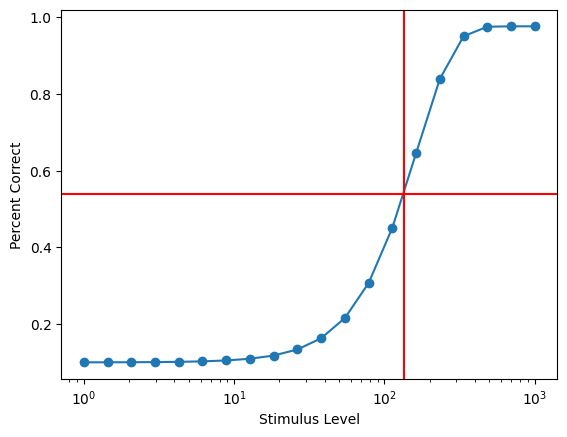

In [4]:
fig, ax = plt.subplots()
ax.semilogx(stimulus_level, perccorr, marker='o')
ax.set_xlabel("Stimulus Level")
ax.set_ylabel("Percent Correct")
plt.axvline(threshold, color='r')
pc = (1 - gamma - lambda_) / 2 + gamma
plt.axhline(pc, color='r')

We construct our data array. In this first case, we have so many trials that the average hit rate is identical to the value on the psychometric function.

Notice that we are going to give to `psignifit` the data in the log-space, so that the fit happens in that space.

In [5]:
ntrials = np.ones(nsteps) * num_trials
hits = (perccorr * ntrials).astype(int)

data = np.dstack([logspace_stimulus_level, hits, ntrials]).squeeze()

We set the options for our fit. In this case we assume a yes/no experiment and we want to estimate all parameters (i.e. fix none).

In [6]:
options = {}
options['sigmoid'] = sigmoid 
options['experiment_type'] = 'yes/no'
options['fixed_parameters'] = {}

Now we run the fitting procedure. We don't need to do anything special about the log-space: since the data lives in that space, the fit is going to happen in that space.

In [7]:
res = psignifit.psignifit(data, **options)

Lastly, we can ensure that the values in our `res.parameter_estimate` dictionary are equal to the values that we used to simulate them. Notice that, since the fit is done in log-space, the parameters that correspond to the stimulus space (threshold and width) are themselves to be interpreted in log-space.

In [8]:
res.parameter_estimate

{'eta': np.float64(1.1102997468934713e-05),
 'gamma': np.float64(0.09998994235987187),
 'lambda': np.float64(0.023218057586713498),
 'threshold': np.float64(4.897830348510321),
 'width': np.float64(2.299983082494156)}

In [9]:
assert np.isclose(res.parameter_estimate['threshold'], log_threshold, atol=1e-4)
assert np.isclose(res.parameter_estimate['width'], log_width, atol=1e-4)

In [10]:
assert np.isclose(res.parameter_estimate['lambda'], lambda_, atol=1e-4)
assert np.isclose(res.parameter_estimate['gamma'], gamma, atol=1e-4)
assert np.isclose(res.parameter_estimate['eta'], 0, atol=1e-4)

Text(0.5, 0, 'log(Stimulus Level)')

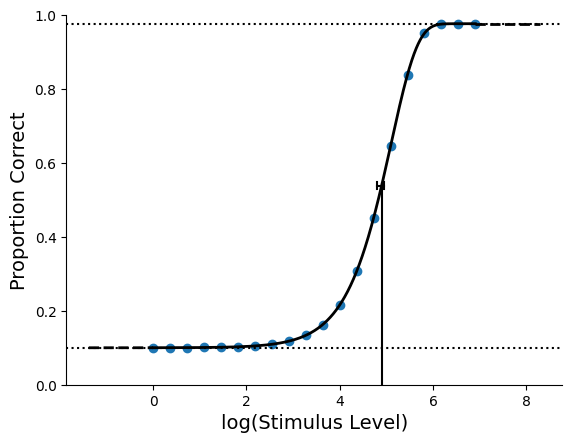

In [11]:
fig, ax = plt.subplots()
psigniplot.plot_psychometric_function(res, ax=ax)
ax.scatter(logspace_stimulus_level, perccorr)
ax.set_xlabel('log(Stimulus Level)')

If we want to interpret the parameters in the original stimulus space, we need a minimum of math:
- The threshold is just a stimulus level in log-space, and can be transformed back to stimulus space by taking its exponential
- The width is a _distance_ between stimulus levels in log-space, and cannot be tranformed back that simply. Instead, we use the definition of width: we measure the log-levels of `alpha` and `1-alpha`, transform them back to stimulus space, and then compute the width.

In [12]:
lin_estimated_threshold = np.exp(res.parameter_estimate['threshold'])
print('Actual threshold in stimulus space:', threshold)
print('Estimated threshold in stimlulus space:', lin_estimated_threshold)

Actual threshold in stimulus space: 134
Estimated threshold in stimlulus space: 133.99873351294596


In [13]:
lin_estimated_width = (
    np.exp(res.threshold(0.95, return_ci=False, unscaled=True)) 
    - np.exp(res.threshold(0.05, return_ci=False, unscaled=True))
)
print('Estimated width in stimlulus space:', lin_estimated_width)

Estimated width in stimlulus space: 275.85061547039305


# And now with some more realistic data...

In [14]:
num_trials = 50  # A smaller number of trials makes the data more noisy
eta = 0.1  # This parameter decides how overdispersed the data is
perccorr = psignifit.tools.psychometric_with_eta(logspace_stimulus_level, log_threshold, log_width, gamma, lambda_, sigmoid, eta)

ntrials = np.ones(nsteps, dtype=int) * num_trials
hits = np.random.binomial(ntrials, perccorr)
data = np.dstack([logspace_stimulus_level, hits, ntrials]).squeeze()

Text(0, 0.5, 'Percent Correct')

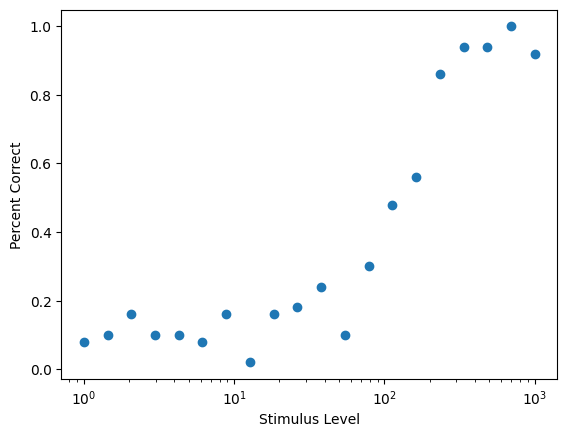

In [15]:
experimental_perccorr = hits/ntrials
fig, ax = plt.subplots()
ax.semilogx(stimulus_level, experimental_perccorr, marker='o', ls='')
ax.set_xlabel("Stimulus Level")
ax.set_ylabel("Percent Correct")

We run the fit again

In [16]:
options = {}
options['sigmoid'] = sigmoid 
options['experiment_type'] = 'yes/no'
options['fixed_parameters'] = {}


In [17]:
res = psignifit.psignifit(data, **options)

pPlot to ensure we found a good fit

In [18]:
res.parameter_estimate

{'eta': np.float64(1.6368768286541344e-08),
 'gamma': np.float64(0.10657984391412699),
 'lambda': np.float64(0.04241157713571423),
 'threshold': np.float64(4.919590140550231),
 'width': np.float64(2.1678348509429406)}

<Axes: xlabel='Stimulus Level', ylabel='Proportion Correct'>

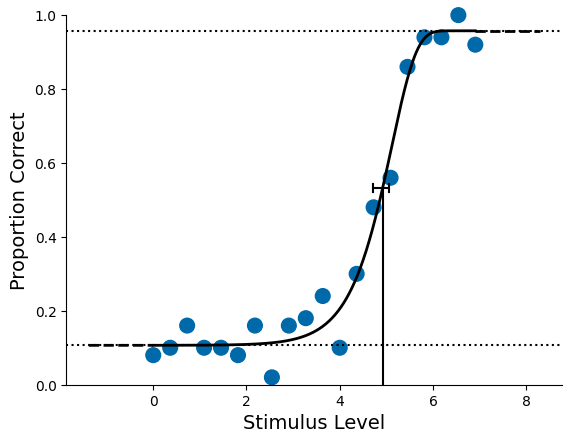

In [19]:
fig, ax = plt.subplots()
psigniplot.plot_psychometric_function(res, ax=ax)

In [20]:
lin_threshold = np.exp(res.parameter_estimate['threshold'])
lin_width = np.exp(res.threshold(0.95, return_ci=False, unscaled=True)) - np.exp(res.threshold(0.05, return_ci=False, unscaled=True))
lin_threshold, lin_width

(np.float64(136.9464728764157), np.float64(264.59379304689736))